# Using vireo for multiplexing, followed by lineage tracing of those groups

# 1. Change to analysis directory

In [2]:
pwd

'/data2/mito_lineage'

## 1.1 Parameters

In [3]:

INDIR="output/clones/CHIP_april08_2021/MTblacklist/merged/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/filter_mgatk/vireoIn"
OUTDIR="output/clones/CHIP_april08_2021/MTblacklist/merged/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/filter_mgatk/vireoIn/multiplex"
N_DONORS=5
sample_names="Control,Flt3l,Input"
to_elbo=False

cores = 8
# INDIR="data/processed/testsets/mttrace/testsetA/merged"
# OUTDIR="data/processed/testsets/mttrace/testsetA/merged/multiplex"
# N_DONORS=2
# sample_names="pre,post"
# to_elbo=False

## 1.2 Import packages

In [5]:
from os.path import join, exists, dirname
from glob import glob
import mplh.cluster_help as ch
import os
from vireoSNP.plot.base_plot import heat_matrix
from vireoSNP import Vireo
import src.pseudo_batch as pb
import vireoSNP
print(vireoSNP.__version__)
import numpy as np
from scipy import sparse
from scipy.io import mmread
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from src.vireo.vireo_utils import run_vireo, plot_vireo_out, extract_clusters, run_elbo, separate_donors
%load_ext autoreload
%autoreload 2

0.5.6


In [6]:
np.set_printoptions(formatter={'float': lambda x: format(x, '.5f')})

## 1.3 Load

In [7]:
AD_F = join(INDIR, "cellSNP.tag.AD.mtx")
DP_F = join(INDIR, "cellSNP.tag.DP.mtx")
cell_inds_names = join(INDIR,"cell_indices_*.txt")
cells_meta_f = join(INDIR, "cells_meta.tsv")
vars_f = join(INDIR, "cellSNP.base.vcf")


In [8]:
vars_df = pd.read_csv(vars_f, sep="\t")
vars_df.head()

,#CHROM,POS,REF,ALT,strand_correlation_x,vmr_x,n_cells_over_5_x,n_cells_over_20_x,index,old output/clones/CHIP_april08_2021/MTblacklist/Control/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/filter_mgatk/vireoIn,...,vmr_y,n_cells_over_5_y,n_cells_over_20_y,old output/clones/CHIP_april08_2021/MTblacklist/Flt3l/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/filter_mgatk/vireoIn,strand_correlation,vmr,n_cells_over_5,n_cells_over_20,old output/clones/CHIP_april08_2021/MTblacklist/Input/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/filter_mgatk/vireoIn,new ID
0,chrM,62,62G,C,1.000000,0.023067,0.0,0.0,62G>C,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,chrM,73,73A,G,0.997152,0.327625,329.0,329.0,73A>G,2.0,...,0.339238,2823.0,2751.0,3.0,0.996919,0.382955,119.0,116.0,1.0,2
2,chrM,150,150C,T,0.977417,0.624277,177.0,177.0,150C>T,3.0,...,0.801082,727.0,676.0,10.0,0.979327,0.670372,61.0,49.0,3.0,3
3,chrM,195,195T,C,0.986475,1.003792,22.0,22.0,195T>C,4.0,...,0.668427,1125.0,1047.0,11.0,0.990257,0.623396,44.0,31.0,4.0,4
4,chrM,248,248A,G,0.768094,4.211685,95.0,88.0,248A>G,5.0,...,1.708703,247.0,227.0,13.0,0.705534,4.216593,24.0,14.0,5.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,chrM,15596,15596G,C,NaN,NaN,NaN,NaN,15596G>C,NaN,...,NaN,NaN,NaN,NaN,1.000000,0.021713,0.0,0.0,173.0,497
497,chrM,15784,15784T,C,NaN,NaN,NaN,NaN,15784T>C,NaN,...,NaN,NaN,NaN,NaN,0.999269,0.358081,1.0,1.0,176.0,498
498,chrM,16433,16433A,T,NaN,NaN,NaN,NaN,16433A>T,NaN,...,NaN,NaN,NaN,NaN,0.997595,0.011517,0.0,0.0,193.0,499
499,chrM,16465,16465C,T,NaN,NaN,NaN,NaN,16465C>T,NaN,...,NaN,NaN,NaN,NaN,0.998655,0.101256,1.0,0.0,194.0,500


In [9]:
# columns are 'ID', 'raw ID', and 'new index'. The first contains the
# suffix with the old id, the new index contains the mapping to the
# outputted subsampled cells, which is 1-based, and the raw ID is the initial cell IDs without the suffix.   
cells_meta = pd.read_csv(cells_meta_f, sep="\t")
cells_meta = cells_meta.sort_values('new index')
print('cells_meta', cells_meta.head())
sample_names = {ind:val for ind,val in enumerate(sample_names.split(","))}
print('sample_names', sample_names)

cells_meta                            ID              raw ID  new index condition
0  AAACTGCTCTCGCGGA-1_Control  AAACTGCTCTCGCGGA-1          1   Control
1  AAAGATGCAGCAACGA-1_Control  AAAGATGCAGCAACGA-1          2   Control
2  AAAGGATGTGCTGTGC-1_Control  AAAGGATGTGCTGTGC-1          3   Control
3  AAAGGATTCAAAGTAG-1_Control  AAAGGATTCAAAGTAG-1          4   Control
4  AAATGCCCAGAAAGAG-1_Control  AAATGCCCAGAAAGAG-1          5   Control
sample_names {0: 'Control', 1: 'Flt3l', 2: 'Input'}


In [10]:
AD = mmread(AD_F).tocsc()
DP = mmread(DP_F).tocsc()
AD_shape = AD.todense().shape
print('AD_shape', AD_shape)
assert(AD_shape[1]) == cells_meta.shape[0] # These should match up.

AD_shape (501, 4875)


## Add in cell IDs to get sample information

# 2 Run vireo to demultiplex

[-27201189.73224294, -15811409.036806732, -15811692.466763288, -44698434.16964744, -15705760.610887088, -38177472.236864865, -15821288.370389711, -42457358.209209755, -27344836.203591138, -12061983.04760196, -48543999.383025475, -15785355.327925645, -15819806.927582353, -30255320.24821002, -15802656.024770442, -29771089.148540534, -15790418.454248108, -12060910.319169093, -41051832.827251166, -36514298.68444948, -15824095.569554988, -15712628.571714338, -34789348.722992085, -34896369.668881744, -34694885.12986001, -29824196.221229427, -15788932.240609836, -15790205.193308331, -15801375.228465822, -42448986.23156028, -15819939.504941717, -34784472.224586986, -15785175.497192666, -27689802.911736667, -46180782.15417795, -15813896.09054565, -15819666.446659341, -15802090.280994538, -43053379.68344566, -33735622.15474787, -15685436.359729603, -46461988.30699509, -15821021.044842314, -15790782.855768315, -15802794.13364264, -29793165.427807003, -15806282.256952431, -34783878.09614192, -3468

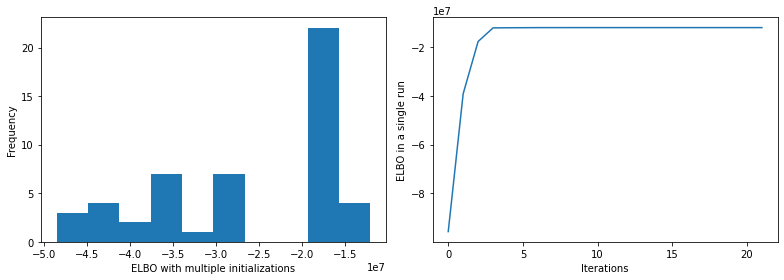

In [12]:
modelCA, elbo = run_vireo(AD, DP, N_DONORS, n_cores=cores, plot_qc=True,out_f=join(OUTDIR, "donors"))
try:
    doublet_prob = modelCA.predict_doublet(AD, DP, update_GT=False, update_ID=False)[0].sum(axis=1)
except AttributeError: # New version of Vireo 2021
    doublet_prob = vireoSNP.utils.vireo_doublet.predict_doublet(modelCA,AD, DP, update_GT=False, update_ID=False)[0].sum(axis=1)

## Extract donors

In [14]:
cell_clusters = separate_donors(AD, DP, modelCA, cells_meta, OUTDIR,
                    doublet_prob,
                    prob_thresh = 0.9, doublet_thresh = 0.9, vars_meta=vars_df)
cell_clusters

ic| 'Before filtering'
ic| cells_meta.shape: (4875, 4)
ic| 'After filtering'
ic| cells_meta.shape: (4875, 5)
ic| allAD.shape: (501, 4875)
ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (4875, 7)


donor 0: 1157 cells 
(63547, 3)
(63547, 3)
donor0


ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (4875, 7)


donor 1: 967 cells 
(49638, 3)
(49638, 3)
donor1


ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (4875, 7)


donor 2: 849 cells 
(26893, 3)
(26893, 3)
donor2


ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (4875, 7)


donor 3: 799 cells 
(42863, 3)
(42863, 3)
donor3


ic| len(curr_dp["Cell"].unique())-len(keep_inds): 0
ic| cells_meta.shape: (4875, 7)


donor 4: 808 cells 
(25873, 3)
(25873, 3)
donor4


{0: array([   3,    5,    7, ..., 4849, 4850, 4859]),
 1: array([  61,   99,  120,  147,  206,  237,  243,  306,  325,  330,  350,
         376,  404,  407,  427,  428,  433,  475,  493,  498,  500,  501,
         507,  509,  516,  523,  535,  542,  543,  550,  554,  555,  560,
         563,  567,  570,  572,  573,  583,  585,  587,  590,  591,  593,
         601,  603,  606,  610,  612,  629,  632,  633,  635,  645,  647,
         658,  659,  664,  667,  669,  671,  678,  680,  681,  683,  695,
         697,  698,  699,  704,  720,  723,  730,  752,  753,  755,  778,
         780,  788,  789,  790,  795,  796,  804,  805,  807,  826,  829,
         836,  837,  842,  847,  848,  849,  855,  862,  864,  869,  878,
         880,  884,  888,  891,  895,  900,  908,  931,  937,  947,  953,
         957,  959,  960,  962,  966,  968,  982,  983,  985,  996, 1001,
        1002, 1009, 1023, 1024, 1029, 1033, 1034, 1035, 1036, 1038, 1051,
        1052, 1056, 1058, 1083, 1086, 1087, 1089, 1092,

In [15]:
if to_elbo:
    run_elbo(AD, DP, out_f=join(OUTDIR, "donors_elbo"), 
             n_clone_list=np.arange(N_DONORS-2, N_DONORS+3), 
             n_cores=cores, cells_meta=cells_meta, save_clusters=False,)

In [ ]:
del AD
del DP

     condition
99     Control
2479     Flt3l
3929     Flt3l
1104     Flt3l
1005     Flt3l
clustering
cmap Oranges
AF_SNPs shape (501, 5)
clustering
cmap Blues


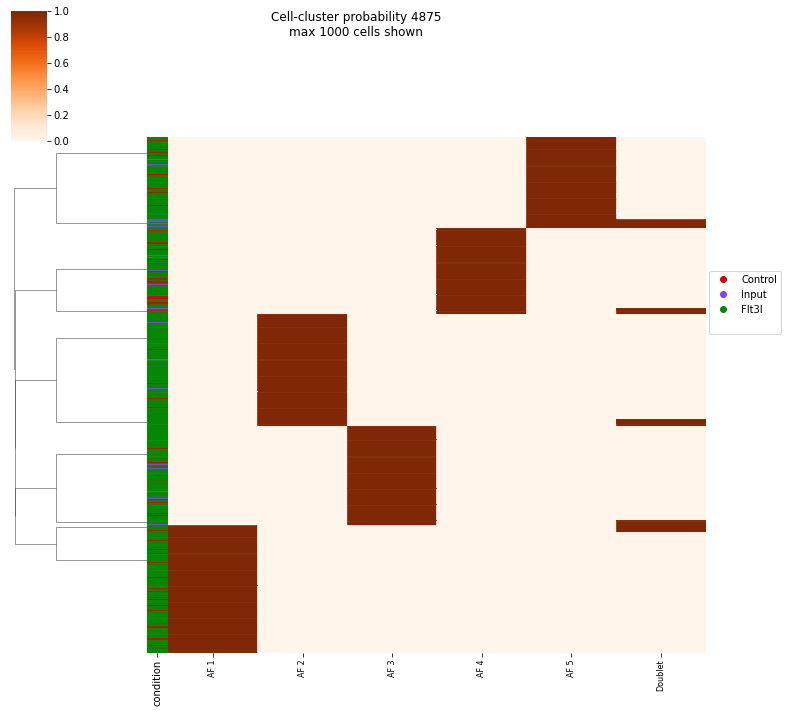

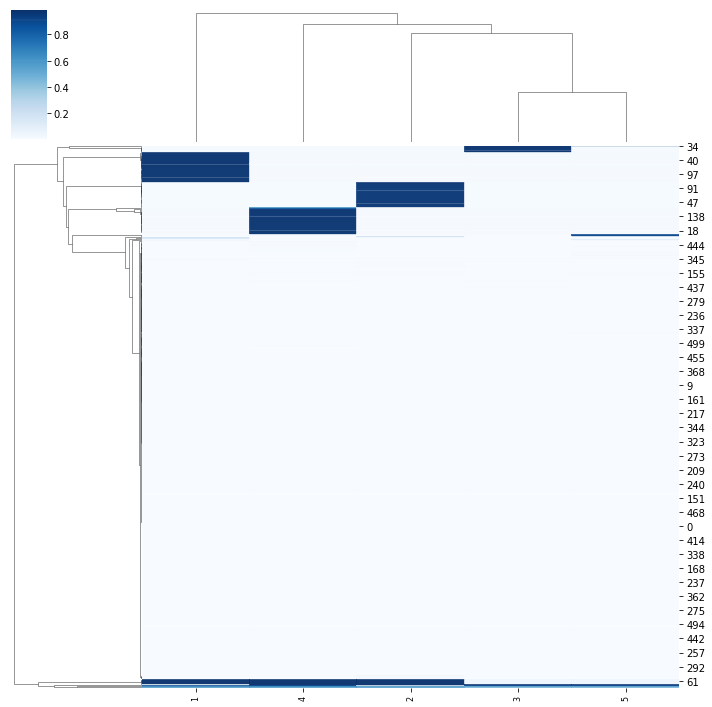

In [18]:
clust_df, AF_SNPs = plot_vireo_out(modelCA, out_f=join(OUTDIR, "multiplex_clusters_all"), labels=cells_meta[['condition']],
                                   to_sqrt=False, doublet_prob=doublet_prob)

Control
             AF 1          AF 2          AF 3          AF 4          AF 5  \
0    8.900741e-08  2.955996e-07  3.613367e-07  1.000000e+00  3.791257e-07   
1    3.321712e-07  1.916231e-07  3.850723e-07  1.000000e+00  4.657328e-07   
2    1.642030e-07  4.370559e-07  1.000000e+00  2.628009e-07  3.347530e-07   
3    1.000000e+00  1.461447e-07  3.129095e-07  8.128027e-08  1.524805e-07   
4    8.023494e-08  1.028992e-07  3.508634e-07  2.569419e-07  1.000000e+00   
..            ...           ...           ...           ...           ...   
483  1.000000e+00  4.572545e-08  3.366103e-07  4.813930e-07  2.880732e-07   
484  2.530552e-08  1.967406e-07  1.355653e-07  1.000000e+00  4.221106e-07   
485  3.981223e-07  1.470963e-08  1.000000e+00  4.958245e-07  2.415997e-07   
486  2.691848e-08  3.145965e-07  3.293653e-07  1.940845e-08  1.000000e+00   
487  1.000000e+00  1.273918e-07  2.603210e-07  3.334061e-07  2.509885e-07   

     Doublet  
0        0.0  
1        0.0  
2        0.0  
3      

<Figure size 432x288 with 0 Axes>

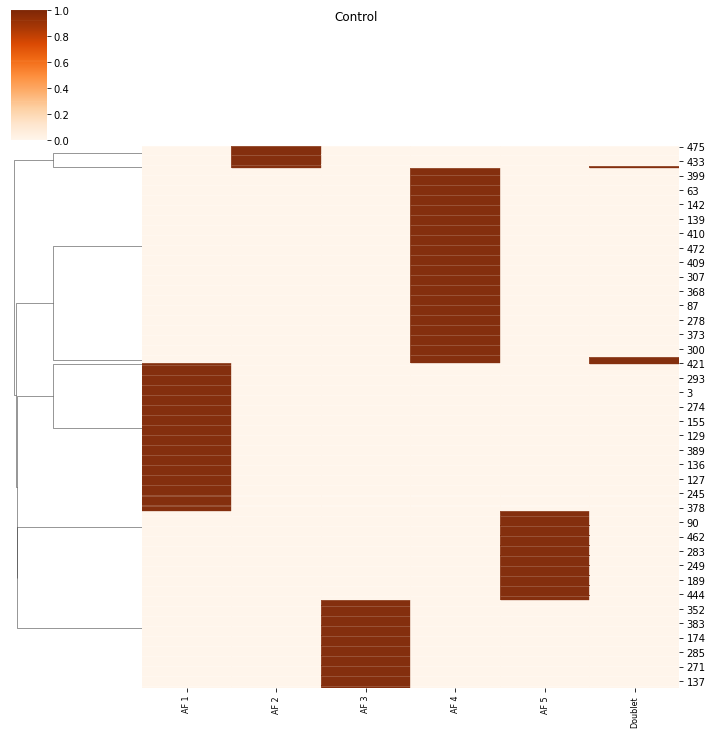

<Figure size 432x288 with 0 Axes>

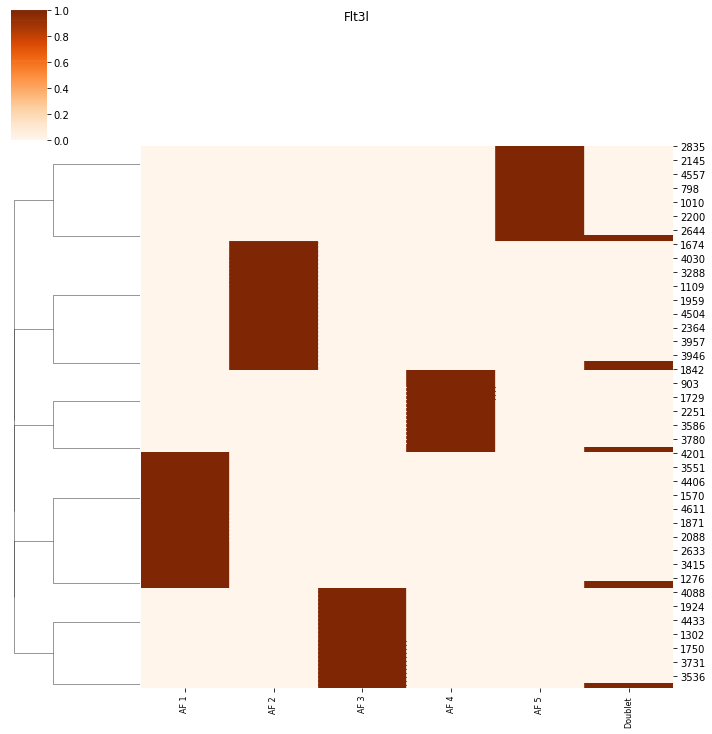

<Figure size 432x288 with 0 Axes>

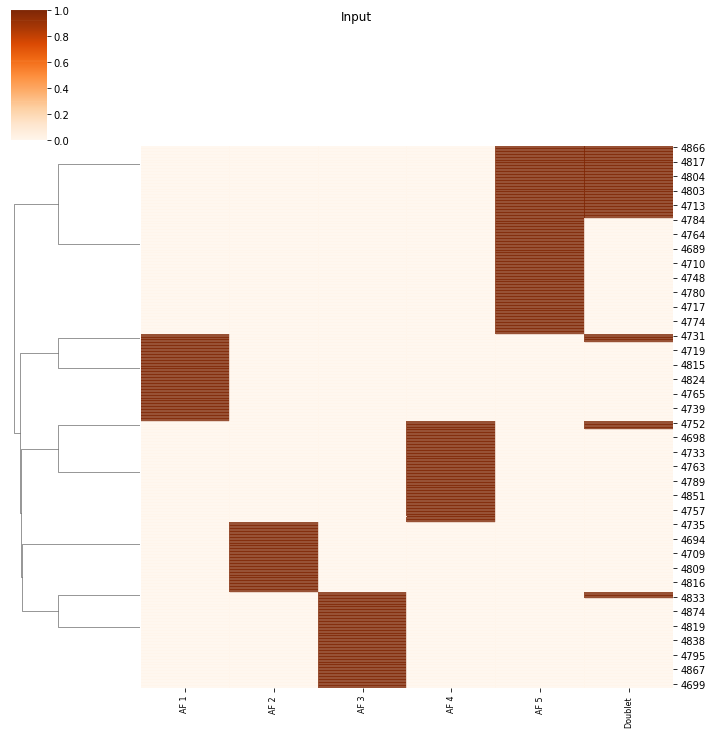

In [19]:
for ind, val in cells_meta.groupby("condition"):
    print(ind)
    print(clust_df.loc[val.index]) #, curr_AF_SNPs
    f = plt.figure()
#     curr_AF_SNPs = AF_SNPs 
#     im = heat_matrix(np.sqrt(curr_AF_SNPs[(curr_AF_SNPs.sum(axis=1)>0.01),:]), cmap="Blues", alpha=0.8,
#             display_value=False, row_sort=True)
    ch.plot_cluster(clust_df.loc[val.index], cmap='Oranges', alpha=0.8,
                to_row_clust=True, to_col_clust=False,
                to_legend=True,
                white_name=None)
    plt.suptitle(ind)
    plt.savefig(join(OUTDIR, f"multiplex_clusters_{ind}"))

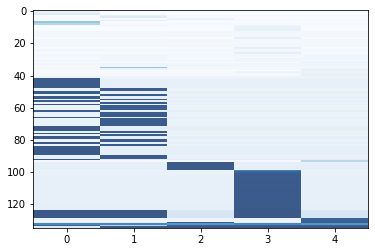

In [20]:
f = plt.figure()
im = heat_matrix(np.sqrt(AF_SNPs[(AF_SNPs.sum(axis=1)>0.01),:]), cmap="Blues", alpha=0.8,
                 display_value=False, row_sort=True)
plt.savefig(join(OUTDIR, "multiplex_AF_SNPs_all_afFilt"))